In [1]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors
import dask.array as da

next step: 

try calculating MFC (the whole term) and see if the advection + conv = MFC

In [41]:
# # reading in ERA-Interim to compare

# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

# eraint_base_path = '/data/rong3/annie/era_int_sgp_2011_uvq'

# file = 'ERAI-SGP-2011-u_v_q_2.nc'

# full_path = os.path.join(eraint_base_path, file) 

# era = xr.open_dataset(full_path)

# era['valid_time'] = era['valid_time'] - pd.Timedelta(hours=6)

# era2011 = era.where(era['valid_time'].dt.year == 2011, drop=True)

# night = era2011.sel(valid_time=era2011['valid_time'].dt.hour.isin([0, 6]))

# day = era2011.sel(valid_time=era2011['valid_time'].dt.hour.isin([12, 18]))

# fullday = era2011.resample(valid_time='ME').mean()

# night = night.resample(valid_time='ME').mean()

# day = day.resample(valid_time='ME').mean()

In [2]:
# reading in ERA5 to compare

base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(1979, 2019)]

def get_files(folder, component):

    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))

    filtered_files = [f for f in files if any(year in f for year in years)]
    
    return filtered_files

# Get the files for each component
u_files = get_files('u_component_of_wind', 'u_component_of_wind')

v_files = get_files('v_component_of_wind', 'v_component_of_wind')

q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files

# open all datasets at once
era5 = xr.open_mfdataset(all_files, combine='by_coords', chunks={'time': 24})

era5sgp = era5.sel(latitude=slice(39.0, 30.0), longitude=slice(-105.0, -95.0))

era5sgp['time'] = era5sgp['time'] - pd.Timedelta(hours=6)

In [3]:
#subsetting for 2011
era2011 = era5sgp.where(era5sgp['time'].dt.year == 2011, drop=True)

night = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6]))

day = era2011.sel(time=era2011['time'].dt.hour.isin([12, 18]))

full = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6, 12, 18]))

night = night.resample(time='ME').mean()

day = day.resample(time='ME').mean()

full = full.resample(time='ME').mean()

In [4]:
#subsetting for climatology
clim = era5sgp.sel(time=slice('1979-01-01', '2018-12-31'))

cnight = clim.sel(time=clim['time'].dt.hour.isin([0, 6]))

cday = clim.sel(time=clim['time'].dt.hour.isin([12, 18]))

cfull = clim.sel(time=clim['time'].dt.hour.isin([0, 6, 12, 18]))

cnight = cnight.groupby('time.month').mean('time')

cday = cday.groupby('time.month').mean('time')

cfull = cfull.groupby('time.month').mean('time')

In [199]:
all_times = {
    
    'clim full': cfull,
    
    '2011 night': night,
    
    '2011 day': day,
        
    'clim night': cnight,
    
    'clim day': cday 
    
}

In [215]:
def moisture_budget_profiles(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    rho_water = 1000 # kg/m^3
    
    seconds_to_day = 60 * 60 * 24 # to convert from s --> day

    latitude_range = np.sin(np.radians(lat[-1])) - np.sin(np.radians(lat[0]))
    
    longitude_range = np.radians(lon[-1]) - np.radians(lon[0])
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    delta_y = np.radians(lat[1]) - np.radians(lat[0])
    delta_x = np.radians(lon[1]) - np.radians(lon[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = np.cos(lat_grid)
    
    v_scaled = v * cos_correction
    
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    dudx = np.zeros_like(u)
    dvdy = np.zeros_like(v)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):
        
        # Central points

        # advection 
    
        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * delta_x)
        dqdy[k, 1:-1, :] = (q[k, 2:, :] - q[k, :-2, :]) / (2 * delta_y)
        
        # divergence 
        
        dudx[k, :, 1:-1] = (u[k, :, 2:] - u[k, :, :-2]) / (2 * delta_x)
        dvdy[k, 1:-1, :] = (v_scaled[k, 2:, :] - v_scaled[k, :-2, :]) / (2 * delta_y)

        # Boundary points (one-sided differences)
        # Left and right boundaries (x-direction)
        
        # advection 
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / (delta_x)
        dqdx[k, :, -1] = (q[k, :, -2] - q[k, :, -1]) / (delta_x)
        
        # divergence
        
        dudx[k, :, 0] = (u[k, :, 1] - u[k, :, 0]) / (delta_x) 
        dudx[k, :, -1] = (u[k, :, -2] - u[k, :, -1]) / (delta_x) 

        # Top and bottom boundaries (y-direction)
        
        # advection 
        
        dqdy[k, 0, :] = (q[k, 1, :] - q[k, 0, :]) / (delta_y)
        dqdy[k, -1, :] = (q[k, -2, :] - q[k, -1, :]) / (delta_y)
        
        # divergence 
        
        dvdy[k, 0, :] = (v_scaled[k, 1, :] - v_scaled[k, 0, :]) / (delta_y) 
        dvdy[k, -1, :] = (v_scaled[k, -2, :] - v_scaled[k, -1, :]) / (delta_y)  
        
        dx = R * cos_correction * delta_x
        dy = R * delta_y

        # for every grid point, multiply by the area extent of that grid box 
        
        dqdy[k] = (1/R) * dqdy[k] * dx * dy
        
        dqdx[k] = (1/(R*cos_correction)) * dqdx[k] * dx * dy
        
        dudx[k] = (1/(R*cos_correction)) * dudx[k] * dx * dy
        
        dvdy[k] = (1/(R*cos_correction)) * dvdy[k] * dx * dy
        
    meridional_advection = -(v * dqdy)
    
    zonal_advection = -(u * dqdx)
    
    meridional_divergence = -(q * dvdy)
    
    zonal_divergence = -(q * dudx)
    
    # Defining the total area of the domain by summing each individual grid box (dx*dy)
    total_area = []
    
    for i in dx: 
        
        total_area.append(i*dy)
        
    A = np.sum(total_area)
    
    # Area weighted average
    zonal_adv_avg = np.sum(zonal_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    merid_adv_avg = np.sum(meridional_advection, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    zonal_div_avg = np.sum(zonal_divergence, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    merid_div_avg = np.sum(meridional_divergence, axis=(1,2))*(1/A)*seconds_to_day*rho_water
    
    # Units = mm/day 
    return zonal_adv_avg, merid_adv_avg, zonal_div_avg, merid_div_avg


# # Vertically integrated moisture flux convergence and its components
# def vertically_integrated_advection(u, v, q, levels, latitude, longitude):

#     g = 9.81  # gravitational acceleration in m/s^2
    
#     rho_water = 1000 # kg/m^3
    
#     zonal_adv_avg, merid_adv_avg, zonal_div_avg, merid_div_avg = moisture_budget_profiles(u, v, q, latitude, longitude)

#     # era-int requires negative dp because starts at surface (decreases)
#     # era5 requires positive dp because starts at top
#     dp = np.diff(levels)
    
#     zonal_div_int = np.zeros_like(zonal_div, dtype=np.float64)
    
#     merid_div_int = np.zeros_like(merid_div, dtype=np.float64)

#     zonal_div_int = np.sum(0.5 * (zonal_div[:-1] + zonal_div[1:]) * dp) / (g*rho_water)
    
#     merid_div_int = np.sum(0.5 * (merid_div[:-1] + merid_div[1:]) * dp) / (g*rho_water)

#     # Units --> mm/day
#     return zonal_div_int, merid_div_int


def vertically_integrated_advection(u, v, q, levels, latitude, longitude):
    
    g = 9.81  # Gravitational acceleration in m/s^2
    
    rho_water = 1000  # Density of water in kg/m^3

    # Get the moisture budget profiles
    zonal_adv_avg, merid_adv_avg, zonal_div_avg, merid_div_avg = moisture_budget_profiles(u, v, q, latitude, longitude)

    # Calculate dp, with the sign depending on your dataset's vertical structure
    dp = np.diff(levels)

    # Create a dictionary to store the input profiles and the integrated results
    profiles = {
        "zonal conv": zonal_div_avg,
        "merid conv": merid_div_avg,
        "zonal adv": zonal_adv_avg,
        "merid adv": merid_adv_avg
    }
    
    integrated_results = {}  # Dictionary to store integrated results

    for name, profile in profiles.items():
        
        integrated_results[name] = np.sum(0.5 * (profile[:-1] + profile[1:]) * dp) / (g * rho_water)

    return integrated_results


In [216]:
u = full['u'].load().data[:, :, ::-1, :] 
print("u loaded")

v = full['v'].load().data[:, :, ::-1, :]  
print("v loaded")

q = full['q'].load().data[:, :, ::-1, :] 
print("q loaded")

levels = full['level'].data * 100 

latitude = full['latitude'].data[::-1]

longitude = full['longitude'].data

zonal_profile = []

merid_profile = []

# Looping over every month
months = u.shape[0]

for i in range(months):

    zonal_adv_avg, merid_adv_avg, zonal_div_avg, merid_div_avg = moisture_budget_profiles(u[i], v[i], q[i], latitude, longitude)
    
    zonal_profile.append(zonal_adv_avg)
    
    merid_profile.append(merid_adv_avg)

u loaded
v loaded
q loaded


In [200]:
results = {}

for df_name, df in all_times.items():
    print(df_name)
    
    identifier = df_name
    
    u = df['u'].load().data[:, :, ::-1, :] 
    print("u loaded")
    
    v = df['v'].load().data[:, :, ::-1, :]
    print("v loaded")
    
    q = df['q'].load().data[:, :, ::-1, :] 
    print("q loaded")
    
    level = df['level'].data * 100 
    
    latitude = df['latitude'].data[::-1]
    
    longitude = df['longitude'].data
    
    months = u.shape[0]
    
    monthly_results = []
    
    for i in range(months):
    
        integrated_results = vertically_integrated_advection(u[i], v[i], q[i], level, latitude, longitude)
   
        r = {
            "zonal adv": integrated_results["zonal adv"],
            "merid adv": integrated_results["merid adv"],
            "zonal conv": integrated_results["zonal conv"],
            "merid conv": integrated_results["merid conv"]
        }
    
        monthly_results.append(r)
        
    results[df_name] = monthly_results
    
#     zonals = []
    
#     merids = []
    
#     # Loop through each month 
#     for i in range(u.shape[0]):
        
#         zonal_int, merid_int = vertically_integrated_advection(u[i], v[i], q[i], level, latitude, longitude)
                
#         zonals.append(zonal_int)
        
#         merids.append(merid_int)

#     results[identifier] = {
        
#         'zonal': zonals,
        
#         'meridional': merids
#     }

clim full
u loaded
v loaded
q loaded
2011 night
u loaded
v loaded
q loaded
2011 day
u loaded
v loaded
q loaded
clim night
u loaded
v loaded
q loaded
clim day
u loaded
v loaded
q loaded


In [201]:
mfc = {} 

for name in all_times:
    
    time = results[name]  
    
    monthly_sums = []  
    
    for i in range(12): 
       
        monthly_sum = sum(time[i].values())
        
        monthly_sums.append(-monthly_sum)
            
    mfc[name] = monthly_sums

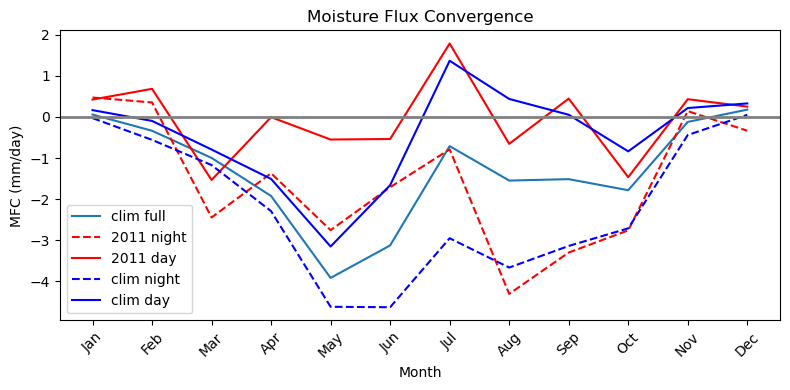

In [202]:
plt.figure(figsize=(8, 4))

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for name, monthly_sums in mfc.items():
    
    if name == '2011 night':
        
        plt.plot(months, monthly_sums, color='red', linestyle='--', label=name)  # Night: red dashed
    
    elif name == '2011 day':
        
        plt.plot(months, monthly_sums, color='red', linestyle='-', label=name)  # Day: red solid
    
    elif name == 'clim night':
        
        plt.plot(months, monthly_sums, color='blue', linestyle='--', label=name)  # Clim night: blue dashed
    
    elif name == 'clim day':
        
        plt.plot(months, monthly_sums, color='blue', linestyle='-', label=name)  # Clim day: blue solid
    
    else:
        # Default color and linestyle for other names
        plt.plot(months, monthly_sums, label=name)

        plt.xlabel('Month')

plt.ylabel('MFC (mm/day)')

plt.title('Moisture Flux Convergence')

plt.axhline(0, color='grey', linewidth=2)

plt.xticks(rotation=45)  

plt.legend()  

plt.tight_layout()
plt.show()

In [213]:
# # zonal

# fig, ax = plt.subplots(figsize=(8, 4))

# months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

# plt.plot(months, results['2011 night']['zonal conv'], color='#b2182b', linestyle='--', label='2011-night')

# plt.plot(months, results['2011 day']['zonal conv'], color='#b2182b', label='2011-day')

# plt.plot(months, results['clim night']['zonal conv'], color='blue', linestyle='--', label='clim-night')

# plt.plot(months, results['clim day']['zonal conv'], color='blue', label='clim-day')

# plt.axhline(0, color='grey', linewidth=2)

# plt.ylabel("mm/day")

# plt.title("Vertically Integrated Zonal Convergence")

# # plt.ylim(-5,2)

# plt.legend()

# plt.show()


# # meridional 

# fig, ax = plt.subplots(figsize=(8, 4))

# months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

# plt.plot(months, results['2011 night']['meridional'], color='#b2182b', linestyle='--', label='2011-night')

# plt.plot(months, results['2011 day']['meridional'], color='#b2182b', label='2011-day')

# plt.plot(months, results['clim night']['meridional'], color='blue', linestyle='--', label='clim-night')

# plt.plot(months, results['clim day']['meridional'], color='blue', label='clim-day')

# plt.axhline(0, color='grey', linewidth=2)

# plt.title("Vertically Integrated Meridional Convergence")

# plt.ylabel("mm/day")

# # plt.ylim(-5,2)

# plt.legend()

# plt.show()

In [218]:
zonal_profile = np.array(zonal_profile)

merid_profile = np.array(merid_profile)

profs_to_plot = [zonal_profile, merid_profile]

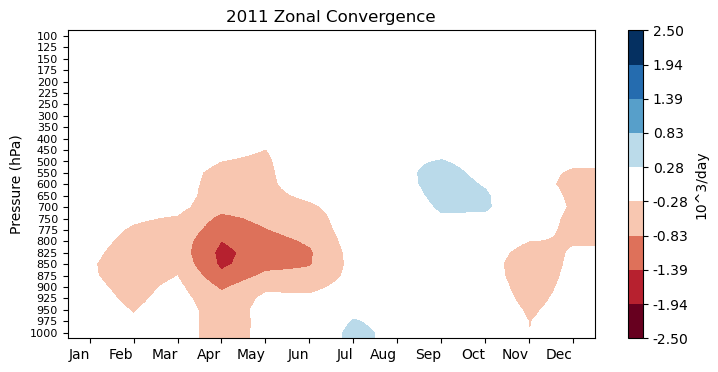

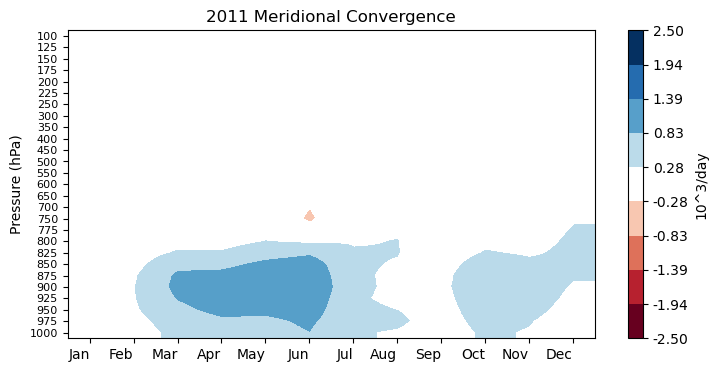

In [220]:
# Define titles and levels
titles = ['Zonal', 'Meridional']

pressure_levels = cfull['level'].data

# Define levels and custom color map
# levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])

# levels = np.array([-3, -2, -1, -0.5, -0.01, 0.01, 0.05, 1, 2, 3])

levels = np.linspace(-2.5, 2.5, 10)

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels and data to go up to 100 hPa
pressure_subset = pressure_levels[pressure_levels >= 100]

pressure_indices = np.where(pressure_levels >= 100)[0]  # Get indices for subsetting the data

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(8.5, 4))
    
    # Subset data to match the pressure range up to 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without forcing extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
               ha='right')
    
    # Directly use the pressure subset for y-axis labels
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset, size=8)
    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
#     cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

#     cbar.ax.set_yticklabels(['-3', '-2', '-1', '-0.5', '-0.01', '0.01', '0.05', '1', '2', '3'])

    cbar.ax.set_yticklabels([f"{level:.2f}" for level in levels])

    # Set title and show plot
    plt.title('2011 {} Convergence'.format(titles[i]))
    plt.gca().invert_yaxis()
    plt.show()

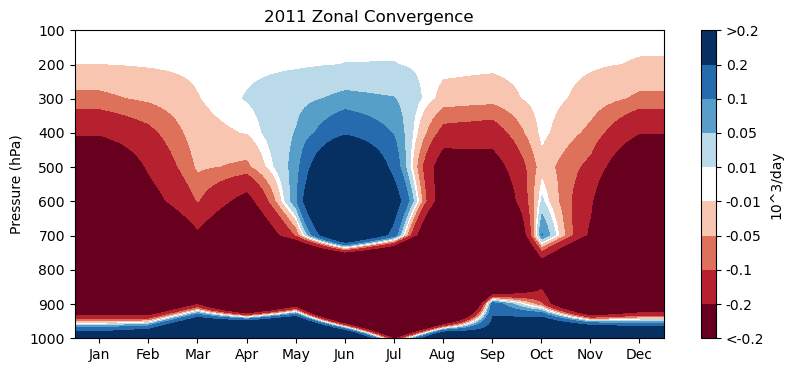

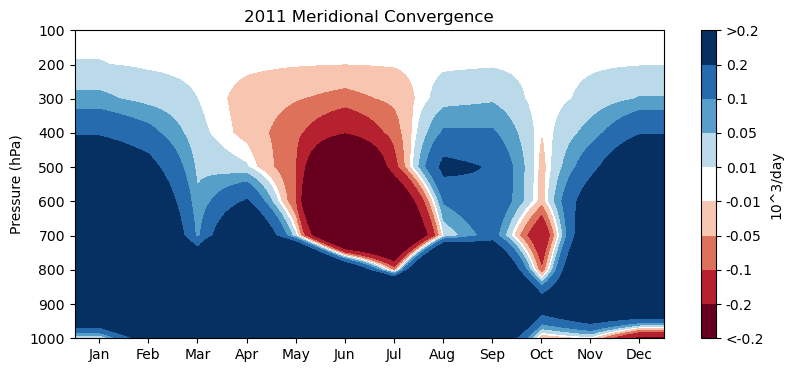

In [72]:
# Define titles and levels
titles = ['Zonal', 'Meridional']

pressure_levels = cfull['level'].data  # Flip if needed for descending order

# Define levels and custom color map
levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])

colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']

cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels) - 1)

norm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=True)

# Subset pressure levels to include only intervals of 100 hPa up to 100 hPa
pressure_subset = pressure_levels[(pressure_levels >= 100) & (pressure_levels % 100 == 0)]

pressure_indices = np.isin(pressure_levels, pressure_subset).nonzero()[0]  # Indices for data subsetting

for i, arr in enumerate(profs_to_plot):
    
    plt.figure(figsize=(9.5, 4))
    
    # Subset data to match the pressure levels at intervals of 100 hPa
    hovmoller_data = np.array(arr)[:, pressure_indices]

    # Plot data without setting extent to allow automatic scaling
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    # Set x-axis labels for months
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ha='center')

    # Set y-axis limits to cover only the pressure levels up to 100 hPa
    plt.ylim(len(pressure_subset) - 1, 0)  # Reverse to show top level first
    
    plt.yticks(np.arange(len(pressure_subset)), pressure_subset)
    
    plt.ylabel('Pressure (hPa)')

    # Color bar with custom tick labels
    cbar = plt.colorbar(label='10^3/day', ticks=levels)
    
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])
    
#     plt.gca().invert_yaxis()

    # Set title and show plot
    plt.title('2011 {} Convergence'.format(titles[i]))
    
    plt.show()
